In [1]:
import numpy as np
import pandas as pd
from scipy.stats import spearmanr
import matplotlib.pyplot as plt
%matplotlib inline

### 1. Top Rising Colleges in terms of the slope of 10 years admitted SAT scores

In [2]:
df_name = pd.read_csv("CollegeScorecard_Raw_Data/MERGED2015_16_PP.csv", usecols=["UNITID", "INSTNM"])
df = pd.read_csv("CollegeScorecard_Raw_Data/MERGED2006_07_PP.csv", usecols=["UNITID", "SAT_AVG"])
for i in range(9):
    year = 2007 + i
    y_str = str(year + 1)[-2:]

    df2 = pd.read_csv("CollegeScorecard_Raw_Data/MERGED%d_%s_PP.csv" % (year, y_str), usecols=["UNITID", "SAT_AVG"])
    df = pd.merge(df, df2, on="UNITID")
    
df = df[~df[df.columns[1:]].isnull().all(axis=1)]

In [3]:
def mean_SAT_rate(x):
    k = x.values[1:]
    k[np.isnan(k)] = k[~np.isnan(k)].mean()
    x = np.array([np.arange(len(k)), np.ones(len(k))]).T
    return np.linalg.lstsq(x, k)[0][0]

In [4]:
df.loc[:, "slope"] = df.apply(lambda x: mean_SAT_rate(x), axis=1)
ddf = df.sort_values(["slope"], ascending=False)
df_res = pd.merge(ddf.iloc[:15], df_name, on="UNITID", how="left")

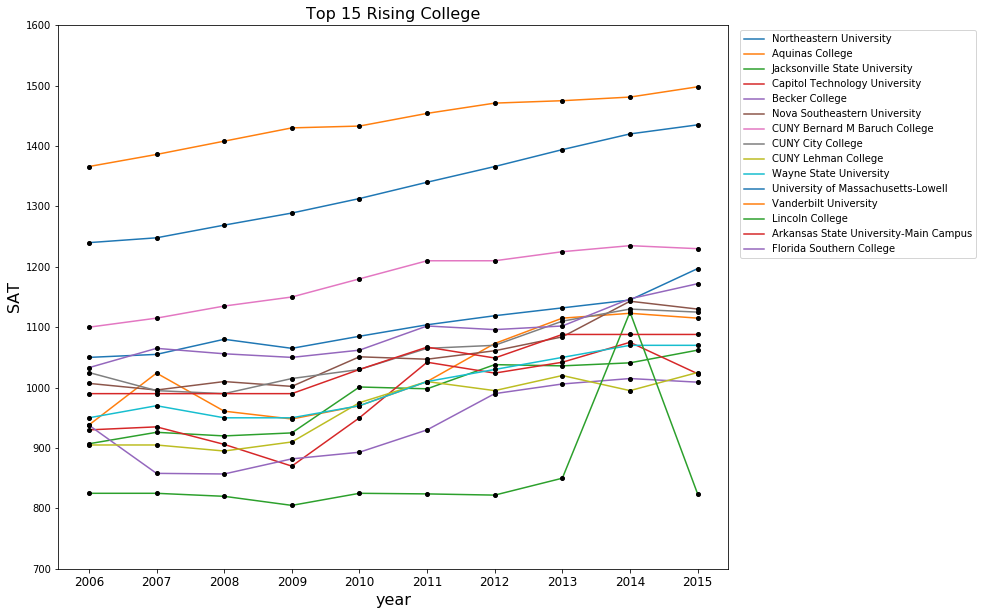

In [5]:
plt.figure(figsize=(12, 10))

for i in range(15):
    data = df_res.iloc[i].values
    sat = data[1:11].astype(np.float)
    sat[np.isnan(sat)] = sat[~np.isnan(sat)].mean()
    plt.plot(np.arange(10) + 2006, sat, label=str(data[-1]))
    plt.plot(np.arange(10) + 2006, sat, 'o', color='k', markersize=4)

plt.ylim([700, 1600])
plt.title("Top 15 Rising College", fontsize=16)
plt.xticks(np.arange(10) + 2006, fontsize=12)
plt.ylabel("SAT", fontsize=16)
plt.xlabel("year", fontsize=16)
plt.legend(bbox_to_anchor=(1.01, 1.0))
plt.savefig("top_growing.jpg", dpi=200, bbox_inches="tight")

### 2. Public vs Private - Cost of Attendence vs Faculty Salary

In [6]:
df = pd.read_csv("CollegeScorecard_Raw_Data/MERGED2015_16_PP.csv",
                 usecols=["AVGFACSAL", "ADM_RATE", "NPT4_PRIV", "NPT4_PUB"])

In [7]:
ddf = df[(~df["AVGFACSAL"].isnull())]
ddf.loc[:, "cost"] = ddf["NPT4_PRIV"]

ddf.loc[~ddf["NPT4_PUB"].isnull(), "cost"] = ddf["NPT4_PUB"][~ddf["NPT4_PUB"].isnull()]
ddf = ddf[(~ddf["cost"].isnull()) & (ddf["cost"] > 0)]

/Users/aaronlai/Desktop/work/venv/lib/python2.7/site-packages/pandas/core/indexing.py:357: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/Users/aaronlai/Desktop/work/venv/lib/python2.7/site-packages/pandas/core/indexing.py:621: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item_labels[indexer[info_axis]]] = value
/Users/aaronlai/Desktop/work/venv/lib/python2.7/site-packages/pandas/core/indexing.py:194: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

In [8]:
pub_faculty = ddf.values[:, -2][~ddf["NPT4_PUB"].isnull()]
pub_costs = ddf["NPT4_PUB"][~ddf["NPT4_PUB"].isnull()].values
pub_coeff = spearmanr(pub_faculty, pub_costs)[0]

priv_faculty = ddf.values[:, -2][~ddf["NPT4_PRIV"].isnull()]
priv_costs = ddf["NPT4_PRIV"][~ddf["NPT4_PRIV"].isnull()].values
priv_coeff = spearmanr(priv_faculty, priv_costs)[0]

print("Public Pearson coeff: %.4f\nPrivate Pearson coeff: %.4f" % (pub_coeff, priv_coeff))

Public Pearson coeff: 0.3908
Private Pearson coeff: 0.4408


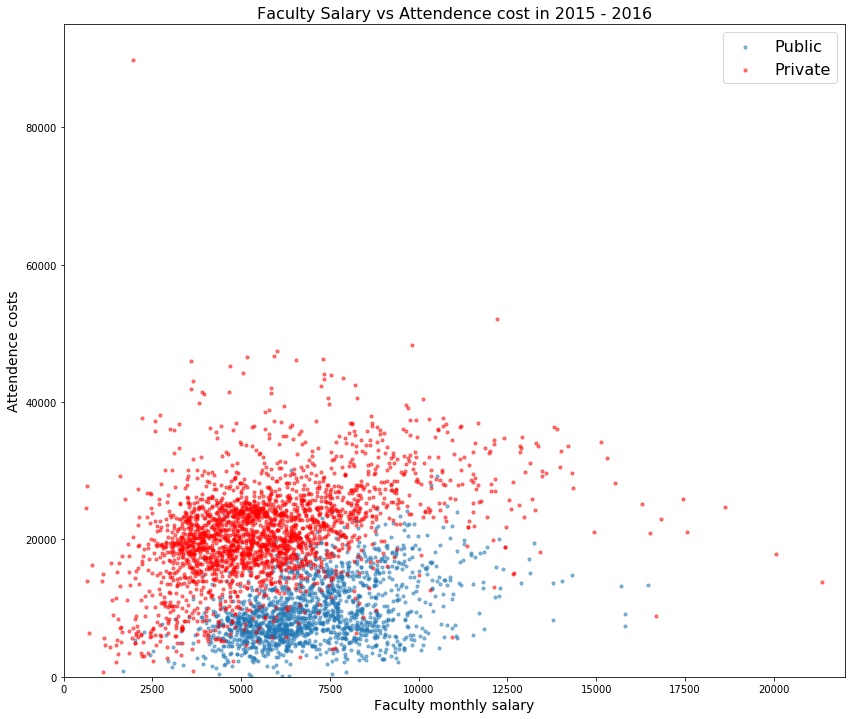

In [9]:
plt.figure(figsize=(14, 12))
plt.scatter(pub_faculty, pub_costs, s=10, alpha=0.5, label="Public")
plt.scatter(priv_faculty, priv_costs, s=10, alpha=0.5, color='R', label="Private")
plt.title("Faculty Salary vs Attendence cost in 2015 - 2016", fontsize=16)
plt.xlim([0, 22000])
plt.ylim([0, 95000])
plt.legend(fontsize=16)
plt.xlabel("Faculty monthly salary", fontsize=14)
plt.ylabel("Attendence costs", fontsize=14)
plt.savefig("cost_salary.jpg", dpi=200)